In [1]:
import pandas as pd

df = pd.read_csv("FPA-FOD_reduced.csv", low_memory = False)

In [3]:
df.head()

,Unnamed: 0,pr,tmmn,tmmx,rmin,rmax,sph,srad,etr,vpd,...,Population,GDP,LATITUDE,LONGITUDE,STATE,COUNTY,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,NWCG_GENERAL_CAUSE
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0000,51481.170,21.574287,-158.107040,HI,Oahu,2007,1,NaN,Missing data/not specified/undetermined
1,1,0.0,269.299988,281.799988,36.700001,92.099998,0.00282,129.100006,2.2,0.35,...,0.0165,47810.750,32.360830,-98.089850,TX,Erath,2007,1,NaN,Debris and open burning
2,2,0.0,276.500000,287.299988,41.799999,90.000000,0.00448,132.900009,3.6,0.47,...,2.6456,55688.996,36.487061,-121.934647,CA,Monterey,2007,1,1537.0,Misuse of fire by a minor
3,3,0.0,275.100006,286.700012,23.900000,75.200005,0.00323,144.300003,3.1,0.61,...,1.1297,47810.750,28.893870,-98.538850,TX,Atascosa,2007,1,NaN,Equipment and vehicle use
4,4,0.9,288.299988,300.299988,49.000000,98.200005,0.01116,109.500000,4.5,0.85,...,0.1981,50591.914,27.508610,-80.758610,FL,Okeechobee,2007,1,1022.0,Fireworks


In [2]:
df = df.drop('Unnamed: 0', axis = 'columns')

In [11]:
df.columns

Index(['pr', 'tmmn', 'tmmx', 'rmin', 'rmax', 'sph', 'srad', 'etr', 'vpd', 'bi',
       'erc', 'fm100', 'fm1000', 'NDVI_mean', 'EVC', 'EVT', 'EVH', 'Elevation',
       'Slope', 'Aspect', 'TRI', 'TPI', 'Aridity_index', 'Population', 'GDP',
       'LATITUDE', 'LONGITUDE', 'STATE', 'COUNTY', 'FIRE_YEAR',
       'DISCOVERY_DOY', 'DISCOVERY_TIME', 'NWCG_GENERAL_CAUSE'],
      dtype='object')

In [13]:
print("Causes:")

for cause in df["NWCG_GENERAL_CAUSE"].unique():
    print("\t", cause)

Causes:
	 Missing data/not specified/undetermined
	 Debris and open burning
	 Misuse of fire by a minor
	 Equipment and vehicle use
	 Fireworks
	 Arson/incendiarism
	 Power generation/transmission/distribution
	 Railroad operations and maintenance
	 Recreation and ceremony
	 Natural
	 Smoking
	 Other causes
	 Firearms and explosives use


# Processing data

In [3]:
unknown_mask = df['NWCG_GENERAL_CAUSE'] == "Missing data/not specified/undetermined"

df_known = df[~unknown_mask].copy()
df_unknown = df[unknown_mask].copy()

In [4]:
X = df_known.drop(columns=['NWCG_GENERAL_CAUSE'])
y = df_known['NWCG_GENERAL_CAUSE']

In [5]:
X = X.fillna(X.median(numeric_only=True)) #replace NANs

for col in X.columns: #convert numeric values to floats, if possible
    if X[col].dtype == 'object':
        # try converting to float — if it works, keep it numeric
        try:
            X[col] = X[col].astype(float)
        except ValueError:
            pass


In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y) #encode the textual output

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_features = ['pr', 'tmmn', 'tmmx', 'rmin', 'rmax', 'sph', 'srad', 'etr', 'vpd',
                    'bi', 'erc', 'fm100', 'fm1000', 'EVC', 'EVT', 'EVH',
                    'Elevation', 'Slope', 'Aspect', 'TRI', 'TPI', 'Aridity_index',
                    'Population', 'GDP', 'LATITUDE', 'LONGITUDE', 'FIRE_YEAR','DISCOVERY_DOY', 'DISCOVERY_TIME']

categorical_features = ['STATE', 'COUNTY']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Model

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=35,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', rf)])

# Split train test

In [11]:
from sklearn.model_selection import train_test_split

# Combine X and y into one DataFrame temporarily
df2 = X.copy()
df2['cause'] = y_encoded

df_balanced = (
    df2.groupby('cause', group_keys=False)
      .apply(lambda x: x.sample(n=min(len(x), 10000), random_state=42))
      .reset_index(drop=True)
)

# Split back into X and y
X_balanced = df_balanced.drop(columns=['cause'])
y_balanced = df_balanced['cause']

# Now do your train-test split as usual
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(X_train.shape, X_test.shape)
print(y_train.value_counts())

(90186, 32) (22547, 32)
cause
11    8000
6     8000
10    8000
8     8000
0     8000
7     8000
2     8000
4     8000
1     8000
5     8000
9     8000
3     2186
Name: count, dtype: int64


/tmp/ipykernel_51/3636907003.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), 10000), random_state=42))


In [12]:
cause_names = [
    "Debris and open burning",
    "Misuse of fire by a minor",
    "Equipment and vehicle use",
    "Fireworks",
    "Arson/incendiarism",
    "Power generation/transmission/distribution",
    "Railroad operations and maintenance",
    "Recreation and ceremony",
    "Natural",
    "Smoking",
    "Other causes",
    "Firearms and explosives use"
]

# Convert y_train value counts into a DataFrame for easier mapping
counts = y_train.value_counts().reset_index()
counts.columns = ['cause_id', 'count']

# Map encoded ID to name
counts['cause_name'] = counts['cause_id'].map(lambda i: cause_names[i])

print(counts[['cause_id', 'cause_name', 'count']].to_string(index=False))

 cause_id                                 cause_name  count
       11                Firearms and explosives use   8000
        6        Railroad operations and maintenance   8000
       10                               Other causes   8000
        8                                    Natural   8000
        0                    Debris and open burning   8000
        7                    Recreation and ceremony   8000
        2                  Equipment and vehicle use   8000
        4                         Arson/incendiarism   8000
        1                  Misuse of fire by a minor   8000
        5 Power generation/transmission/distribution   8000
        9                                    Smoking   8000
        3                                  Fireworks   2186


In [13]:
X_train

,pr,tmmn,tmmx,rmin,rmax,sph,srad,etr,vpd,bi,...,Aridity_index,Population,GDP,LATITUDE,LONGITUDE,STATE,COUNTY,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME
112173,0.0,289.299988,305.600006,34.500000,78.099998,0.01047,279.000000,5.9,1.68,22.0,...,0.75,0.0380,29129.756,33.172944,-89.923202,MS,Holmes,1995,250,1400.0
104451,0.0,287.600006,303.399994,32.100002,95.700005,0.01010,256.300018,6.7,1.35,32.0,...,0.73,0.0000,67082.420,39.770000,-74.679000,NJ,Burlington,2015,249,2300.0
57302,3.6,295.299988,308.600006,38.400002,100.000000,0.01639,357.899994,8.2,1.56,0.0,...,0.42,0.0000,50895.010,29.821390,-81.520000,FL,St. Johns,2006,217,1600.0
100210,0.0,273.200012,286.600006,24.100000,63.200001,0.00276,216.400009,3.8,0.67,33.0,...,0.26,0.0042,45981.348,47.647800,-114.345600,MT,NaN,2020,82,2200.0
74912,0.0,274.600006,283.399994,36.400002,66.200005,0.00310,258.899994,5.3,0.49,59.0,...,0.78,0.0150,42784.630,46.262150,-89.783430,WI,Vilas,2010,106,1342.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13394,0.0,269.399994,289.600006,14.500000,67.900002,0.00213,134.699997,4.0,0.83,30.0,...,0.52,0.0588,44132.895,36.181917,-79.032250,NC,Guilford,2012,331,1206.0
40517,0.0,286.899994,300.299988,25.400000,98.200005,0.00749,321.600006,11.3,1.46,55.0,...,0.28,0.0380,34003.996,45.005800,-101.236000,SD,NaN,1994,178,1815.0
34185,0.0,283.200012,304.399994,10.300000,40.799999,0.00455,301.500000,13.2,2.33,95.0,...,0.31,0.0380,33327.445,33.275100,-105.720000,NM,NaN,1998,175,2030.0
36733,0.0,291.700012,305.100006,24.300001,72.000000,0.00948,322.100006,9.6,2.04,48.0,...,0.22,0.0791,45472.777,43.317200,-101.016700,SD,NaN,2006,184,1540.0


In [14]:
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   56.0s finished


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [16]:
y_pred = model.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.3s finished


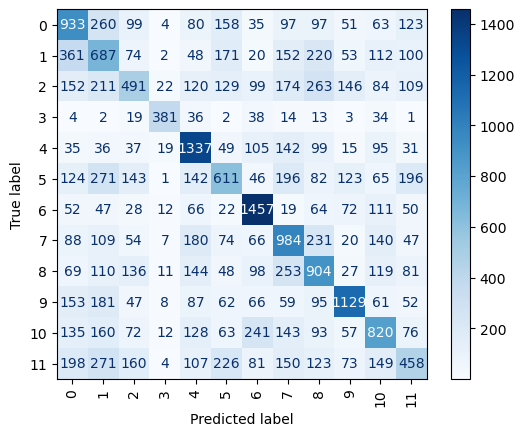

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation='vertical')


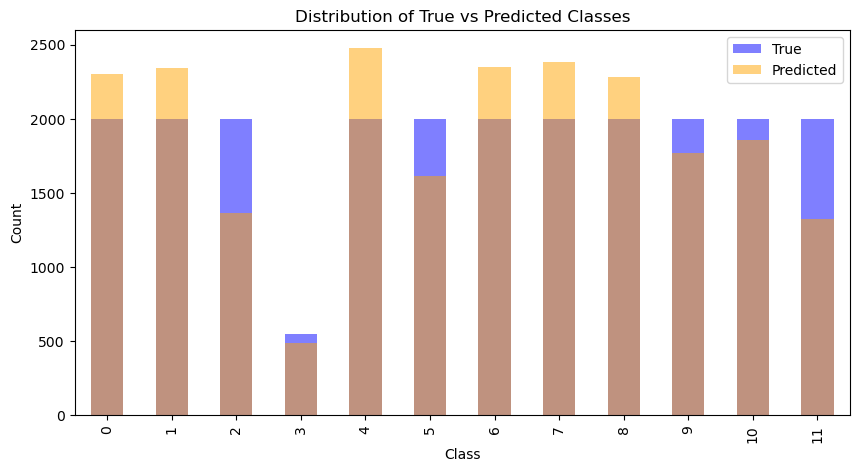

In [20]:
import matplotlib.pyplot as plt

df_compare = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

plt.figure(figsize=(10,5))
df_compare['y_test'].value_counts().sort_index().plot(kind='bar', alpha=0.5, label='True', color='blue')
df_compare['y_pred'].value_counts().sort_index().plot(kind='bar', alpha=0.5, label='Predicted', color='orange')
plt.legend()
plt.title('Distribution of True vs Predicted Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [29]:
print(list(le.classes_))


['Arson/incendiarism', 'Debris and open burning', 'Equipment and vehicle use', 'Firearms and explosives use', 'Fireworks', 'Misuse of fire by a minor', 'Natural', 'Other causes', 'Power generation/transmission/distribution', 'Railroad operations and maintenance', 'Recreation and ceremony', 'Smoking']


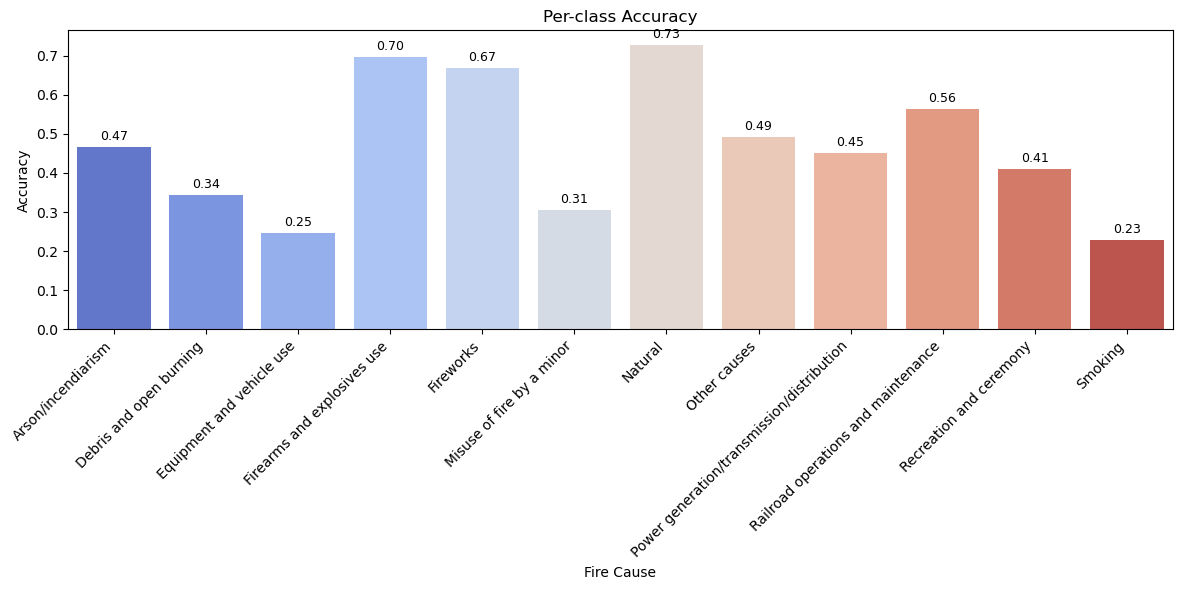

In [31]:
import seaborn as sns
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class_labels = {0:'Arson/incendiarism', 
                1:'Debris and open burning', 
                2:'Equipment and vehicle use', 
                3:'Firearms and explosives use', 
                4:'Fireworks', 
                5:'Misuse of fire by a minor', 
                6:'Natural', 
                7:'Other causes', 
                8:'Power generation/transmission/distribution', 
                9:'Railroad operations and maintenance', 
                10:'Recreation and ceremony', 
                11:'Smoking'}

classes = sorted(class_labels.keys())
class_acc = []

for c in classes:
    mask = (y_test == c)
    if mask.sum() > 0:  # avoid divide-by-zero if class not present
        class_acc.append(accuracy_score(y_test[mask], y_pred[mask]))
    else:
        class_acc.append(np.nan)

plt.figure(figsize=(12, 6))
bars = sns.barplot(x=[class_labels[c] for c in classes], y=class_acc, palette='coolwarm', hue=[class_labels[c] for c in classes],legend=False)
plt.title('Per-class Accuracy')
plt.xlabel('Fire Cause')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')

for bar, acc in zip(bars.patches, class_acc):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{acc:.2f}', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [32]:
import joblib

joblib.dump(model, 'random_forest_model_1.joblib')


['random_forest_model_1.joblib']